# Simple Camera Models with NumPy and Matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from camera_models import *  # our package


DECIMALS = 2  # how many decimal places to use in print


%matplotlib notebook
%load_ext autoreload
%autoreload 2

> **Disclaimer**: The theory described in this notebook is almost entirely taken from the excellent book [Multiple View Geometry in Computer Vision](https://www.robots.ox.ac.uk/~vgg/hzbook/) by Richard Hartley and Andrew Zisserman. This work is not intended to replace the explanations in the book, but only to present the minimum amount of theory needed so that it can be applied immediately thereafter. 

## The Pinhole Camera Model

![title](figures/Pinhole-camera.svg)
Image by Bob Mellish, distributed under a [CC BY-SA 3.0 license](https://creativecommons.org/licenses/by-sa/3.0/deed.en).

A **pinhole camera** is a camera with a pinhole aperture and no lens, it is considered the most specialised and simplest camera model. As can be seen from the image above, the **image plane**, also called the **focal plane**, is behind the projection centre called the **camera centre** ($\boldsymbol{\rm C}$) or **optical centre**. In what follows, for the sake of simplicity, it is considered to be in front of it, leaving the distance between the two unchanged. The image generated in the plane we will consider is simply the upside-down version of that of the real pinhole camera (and will therefore be upright).

## Homogeneous Coordinates

In what follows, we will use **homogeneous coordinates** to simplify some operations.

To transform a vector into homogeneous coordinates just add a 1 at the end of it:

In [2]:
X = np.array([4.0, 2.0, 3.0])
print(f"X: {X}")
Xh = to_homogeneus(X)
print(f"X in homogeneous coordinates: {Xh}")

X: [4. 2. 3.]
X in homogeneous coordinates: [4. 2. 3. 1.]


To go from homogeneous coordinates to normal coordinates just divide all elements by the last coordinate and remove it:

In [3]:
Xh = np.array([8.0, 4.0, 6.0, 2.0])
print(f"X in homogeneous coordinates: {Xh}")
X = to_inhomogeneus(Xh)
print(f"X: {X}")

X in homogeneous coordinates: [8. 4. 6. 2.]
X: [4. 2. 3.]


If you look carefully above, you will see that $\begin{pmatrix}4.0 & 2.0 & 3.0 & 1.0\end{pmatrix}$ and $\begin{pmatrix}8.0 & 4.0 & 6.0 & 2.0\end{pmatrix}$ are two equivalent representations in homogeneous coordinates of the same vector $\begin{pmatrix}4.0 & 2.0 & 3.0\end{pmatrix}$. In general, $\begin{pmatrix}x & y & z & 1.0\end{pmatrix}$ and $\begin{pmatrix}kx & ky & kz & k\end{pmatrix}$ are equivalent in homogeneous coordinates, so the points are represented by **equivalence classes**, where two points are equivalent when they differ by a common multiple.

> **Note**: Where not explicitly specified, the use or non-use of homogeneous coordinates will be clear from the context.

## Camera Translation and Rotation

Points in space are expressed in term of the **world coordinate frame**. The camera will often be translated and rotated relative to it. The parameters of $\rm R$, the $3 \times 3$ **rotation matrix** representing the orientation of the **camera coordinate frame** and $\boldsymbol{\rm C}$, the coordinates of the camera centre in the world coordinate frame, are called the **external** parameters or the **exterior orientation**.

### Camera Translation

Since we will express the coordinates of the camera with respect to the world coordinate frame (whose origin $\boldsymbol{\rm O}$ is equal to $\boldsymbol{\rm 0} = \begin{pmatrix}0.0 & 0.0 & 0.0\end{pmatrix}$), the translation vector $\boldsymbol{\rm t}$ will be equivalent to the camera center, since $\boldsymbol{\rm C} = \boldsymbol{\rm O} + \boldsymbol{\rm t} = \boldsymbol{\rm 0} + \boldsymbol{\rm t} = \boldsymbol{\rm t}$.

> **Note**: Unfortunately Matplotlib does not yet have the option "set aspect equal" for Axes3D, which is why some figures are visually distorted (too long or too short in some directions).

<IPython.core.display.Javascript object>


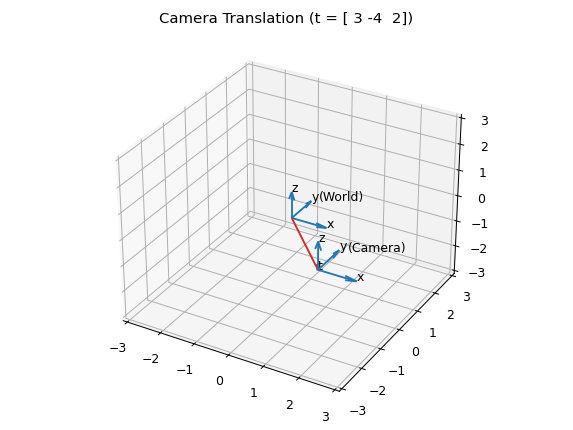

In [4]:
world_origin = np.zeros(3)
dx, dy, dz = np.eye(3)
t = np.array([3, -4, 2])
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
camera_frame = ReferenceFrame(
    origin=t,
    dx=dx, 
    dy=dy,
    dz=dz,
    name="Camera",
)

ax = plt.axes(projection="3d")
world_frame.draw3d()
camera_frame.draw3d()
draw3d_arrow(world_origin, t, color="tab:red", name="t")
set_xyzlim3d(-3, 3)
ax.set_title(f"Camera Translation (t = {t})")
plt.tight_layout()
plt.show()

### Camera Rotation

![title](figures/638px-Yaw_Axis_Corrected.svg.png)
Image by Auawise, distributed under a [CC BY-SA 3.0 license](https://creativecommons.org/licenses/by-sa/3.0/deed.en).

Any rotation represented by a matrix $\rm R$ can be broken down into three rotations with respect to the X, Y and Z axes as

$$
\rm R = \rm R_z \rm R_y \rm R_x = 
\begin{bmatrix}
\cos \theta_z & -\sin \theta_z & 0 \\
\sin \theta_z &  \cos \theta_z & 0 \\
 0            &   0            & 1 \\
\end{bmatrix}
\begin{bmatrix}
 \cos \theta_y & 0 & \sin \theta_y \\
  0            & 1 &  0 \\
-\sin \theta_y & 0 & \cos \theta_y \\
\end{bmatrix}
\begin{bmatrix}
1 &  0            &   0 \\
0 & \cos \theta_x & -\sin \theta_x \\
0 & \sin \theta_x &  \cos \theta_x \\
\end{bmatrix}
= 
\begin{bmatrix}
\cos\theta_z\cos\theta_y & \cos\theta_z\sin\theta_y\sin\theta_x - \sin\theta_z\cos\theta_x & \cos\theta_z\sin\theta_y\cos\theta_x + \sin\theta_z\sin\theta_x \\
\sin\theta_z\cos\theta_y & \sin\theta_z\sin\theta_y\sin\theta_x + \cos\theta_z\cos\theta_x & \sin\theta_z\sin\theta_y\cos\theta_x - \cos\theta_z\sin\theta_x \\
-\sin\theta_y & \cos\theta_y\sin\theta_x & \cos\theta_y\cos\theta_x \\
\end{bmatrix}\,.
$$

The angles $\theta_x$, $\theta_y$ and $\theta_z$ are often called **Euler angles** or, more correctly **Tait–Bryan angles**, given that in the original Euler formulation the same axis was considered twice (Z-X-Z, Y-X-Y, etc.). These angles are also associated with the concepts of **roll**, **pitch** and **yaw** (see the image above).

<IPython.core.display.Javascript object>


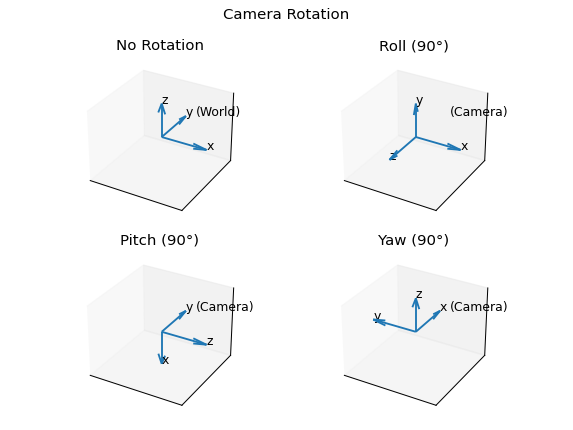

In [5]:
Rx = get_rotation_matrix(theta_x=np.pi / 2.0)
Ry = get_rotation_matrix(theta_y=np.pi / 2.0)
Rz = get_rotation_matrix(theta_z=np.pi / 2.0)
dx, dy, dz = np.eye(3)
world_frame = ReferenceFrame(
    origin=np.zeros(3), 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
roll_frame = ReferenceFrame(
    origin=np.zeros(3), 
    dx=Rx @ dx, 
    dy=Rx @ dy,
    dz=Rx @ dz,
    name="Camera",
)
pitch_frame = ReferenceFrame(
    origin=np.zeros(3), 
    dx=Ry @ dx, 
    dy=Ry @ dy,
    dz=Ry @ dz,
    name="Camera",
)
yaw_frame = ReferenceFrame(
    origin=np.zeros(3), 
    dx=Rz @ dx, 
    dy=Rz @ dy,
    dz=Rz @ dz,
    name="Camera",
)
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1, projection="3d")
world_frame.draw3d()
set_xyzlim3d(-1, 1)
set_xyzticks([])
ax.set_title(f"No Rotation")

ax = fig.add_subplot(2, 2, 2, projection="3d")
roll_frame.draw3d()
set_xyzlim3d(-1, 1)
ax.set_title(f"Roll (90°)")
set_xyzticks([])

ax = fig.add_subplot(2, 2, 3, projection="3d")
pitch_frame.draw3d()
set_xyzlim3d(-1, 1)
set_xyzticks([])
ax.set_title(f"Pitch (90°)")

ax = fig.add_subplot(2, 2, 4, projection="3d")
yaw_frame.draw3d()
set_xyzlim3d(-1, 1)
set_xyzticks([])
ax.set_title(f"Yaw (90°)")

fig.suptitle("Camera Rotation")
plt.tight_layout()
plt.show()

## Pinhole Camera Geometry

Let's define some quantities:
* **Focal length** ($f$): distance between the camera centre and the image plane.
* **Principal axis** or **Principal ray** ($\rm Z$) of the camera: line from the camera centre perpendicular to the image plane.
* **Principal point** ($\boldsymbol{\rm p}$): point where the principal axis meets the image plane, its coordinates with respect to the reference system of the image are $(p_x, p_y)^\top$.

We can now visually represent the pinhole camera geometry.

In [6]:
F = 3.0  # focal length
PX= 2.0  # principal point x-coordinate
PY= 1.0  # principal point y-coordinate
THETA_X = np.pi / 2  # roll angle
THETA_Z = np.pi  # yaw angle
C = np.array([3, -5, 2])  # camera centre
IMAGE_HEIGTH = 4
IMAGE_WIDTH = 6

In [7]:
R = get_rotation_matrix(theta_x=THETA_X, theta_z=THETA_Z)
world_origin = np.zeros(3)
dx, dy, dz = np.eye(3)
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
camera_frame = ReferenceFrame(
    origin=C, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=camera_frame.origin,
    camera_dz=camera_frame.dz,
    f=F,
)
image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Image",
)
image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)

<IPython.core.display.Javascript object>


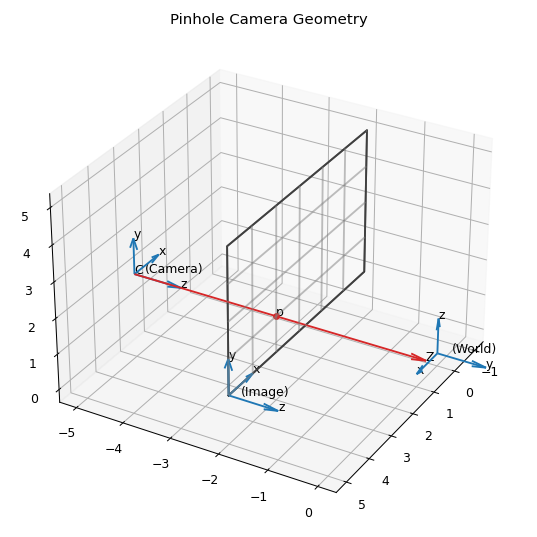

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
ax.text(*C, "C")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()
ax.view_init(elev=30.0, azim=30.0)
ax.set_title("Pinhole Camera Geometry")
plt.tight_layout()
plt.show()

## Representation of a Generic Point in 3D

### Intersection Between a Line and a Plane

We now add a generic point $\boldsymbol{\rm X}$ in space and see how it is represented in the image plane.

Let us consider the line joining the camera centre $\boldsymbol{\rm C}$ with the point $\boldsymbol{\rm X}$, both represented in homogeneous coordinates. We can represent this line with a $4 \times 4$ skew-symmetric homogeneous matrix, called its **plücker matrix**, that is defined as

$$
\rm L = \boldsymbol{\rm C}\boldsymbol{\rm X}^\top - \boldsymbol{\rm X}\boldsymbol{\rm C}^\top \,.
$$

We can also find the representation in homogeneous coordinates of the image plane $\boldsymbol \pi$ starting from three points on it. For example we can use the origin of the image frame that we call $\boldsymbol{\rm X_1} = \begin{pmatrix}\boldsymbol{\rm \tilde{X}_1} \\ 1\end{pmatrix}$ and the two points $\boldsymbol{\rm X_2} = \begin{pmatrix}\boldsymbol{\rm \tilde{X}_2} \\ 1\end{pmatrix} = \boldsymbol{\rm X_1} + d_x$ and $\boldsymbol{\rm X_3} = \begin{pmatrix}\boldsymbol{\rm \tilde{X}_3} \\ 1\end{pmatrix} = \boldsymbol{\rm X_1} + d_y$ and apply the formula

$$
\boldsymbol \pi = \begin{bmatrix}
(\boldsymbol{\rm \tilde{X}_1} - \boldsymbol{\rm \tilde{X}_3}) \times (\boldsymbol{\rm \tilde{X}_2} - \boldsymbol{\rm \tilde{X}_3}) \\
-\boldsymbol{\rm \tilde{X}_3}^\top (\boldsymbol{\rm \tilde{X}_1} - \boldsymbol{\rm \tilde{X}_2})
\end{bmatrix} \,.
$$

Now that we have all the ingredients, the intersection between the line $\rm L$ and the plane $\boldsymbol \pi$ is simply

$$
\boldsymbol{x} = \rm L \boldsymbol \pi \,.
$$

In [9]:
X = np.array([-1, 2, 3])
G = GenericPoint(X, name="X")
L = get_plucker_matrix(C, X)
X1 = image_frame.origin
X2 = X1 + image_frame.dx
X3 = X1 + image_frame.dy
pi = get_plane_from_three_points(X1, X2, X3)
x = to_inhomogeneus(L @ pi)
print(f"X:\n{X}")
print(f"\nL:\n{L.round(DECIMALS)}")
print(f"\nX1:\n{X1}")
print(f"\nX2:\n{X2}")
print(f"\nX3:\n{X3}")
print(f"\npi:\n{pi.round(DECIMALS)}")
print(f"\nx:\n{x.round(DECIMALS)}")

X:
[-1  2  3]

L:
[[  0   1  11   4]
 [ -1   0 -19  -7]
 [-11  19   0  -1]
 [ -4   7   1   0]]

X1:
[ 5. -2.  1.]

X2:
[ 4. -2.  1.]

X3:
[ 5. -2.  2.]

pi:
[0. 1. 0. 2.]

x:
[ 1.29 -2.    2.43]


If you look closely at the homogeneous coordinates of the plane $\boldsymbol \pi = \begin{pmatrix}\pi_1 & \pi_2 & \pi_3 & \pi_4\end{pmatrix}^\top$, you will notice that the first three correspond to the plane normal $\boldsymbol{\rm n}$ of Euclidean geometry while the last is the distance of the plane from the origin. An equivalently representation of the plane would be, for example, $4 \cdot \begin{pmatrix}0 & 1 & 0 & 2\end{pmatrix} = \begin{pmatrix}0 & 4 & 0 & 8\end{pmatrix}$, in this case the distance of the plane from the origin is $\pi_4 / \| \boldsymbol{\rm n} \| = 8 / 4 = 2$ as before.

<IPython.core.display.Javascript object>


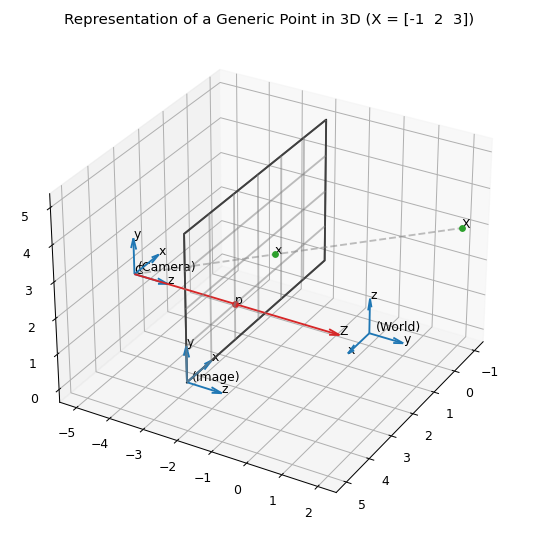

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
ax.text(*C, "C")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()
G.draw3d(pi, C=C)
ax.view_init(elev=30.0, azim=30.0)
ax.set_title(f"Representation of a Generic Point in 3D (X = {X})")
plt.tight_layout()
plt.show()

## Camera Calibration Matrix

We now introduce a new matrix $\rm K$, called the **camera calibration matrix**, that contains what are called the **internal** camera parameters, or **internal orientation** of the camera.

$$
\rm K = \begin{bmatrix}
f & 0        & p_x \\
 0       & f & p_y \\
 0       & 0        & 1 \\
\end{bmatrix}\,.
$$

If we assume that the camera centre coincides with the origin of the world coordinate frame and that there is no rotation, the **image point** $\boldsymbol{\rm x}$ is given by $\boldsymbol{\rm x} = \rm K [I | 0] X$, we call $\rm P =  K [I | 0]$ the **camera projection matrix**.

In [11]:
F = 3.0  # focal length
PX= 2.0  # principal point x-coordinate
PY= 1.0  # principal point y-coordinate
IMAGE_HEIGTH = 4
IMAGE_WIDTH = 6

In [12]:
X = np.array([-1, 2, 3])
Xh = to_homogeneus(X)
K = get_calibration_matrix(F, px=PX, py=PY)
P = get_projection_matrix(F, px=PX, py=PY)
xh = P @ Xh
x = to_inhomogeneus(xh)
print("\nX:\n", X)
print("\nCalibration matrix (K):\n", K)
print("\nProjection matrix (P):\n", P)
print("\nx:\n", x)


X:
 [-1  2  3]

Calibration matrix (K):
 [[3. 0. 2.]
 [0. 3. 1.]
 [0. 0. 1.]]

Projection matrix (P):
 [[3. 0. 2. 0.]
 [0. 3. 1. 0.]
 [0. 0. 1. 0.]]

x:
 [1. 3.]


In [13]:
image = Image(heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH)
G = GenericPoint(X, name="X")

<IPython.core.display.Javascript object>


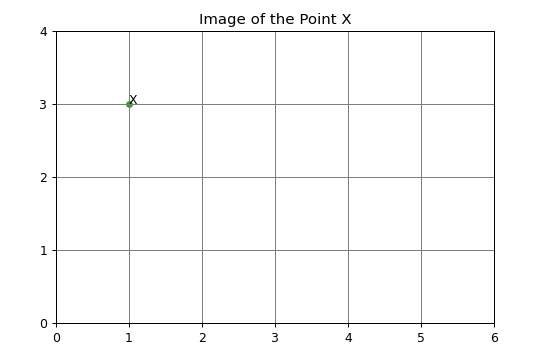

In [14]:
fig = plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGTH))
ax = fig.gca()
image.draw()
G.draw(F, px=PX, py=PY)
ax.set_title("Image of the Point X")
plt.tight_layout()
plt.show()

## CCD Cameras

To give an example of how the pinhole camera model can be extended, we will now consider a **CCD camera**. Unlike the pinhole camera which assumes square pixels, in this case we admit the possibility of having rectangular pixels. The **number of pixels per unit distance in image coordinates** are $m_x$ and $m_y$ in the x and y directions, the transformation from world coordinate to pixels coordinate is then obtained by premultiplying the calibration matrix on the left by an extra factor $\rm diag{(m_x, m_y, 1)}$. Thus, the general form of the calibration matrix of a CCD camera is

$$
\rm K = \begin{bmatrix}
m_x & 0   & 0 \\
0   & m_y & 0 \\
0   & 0   & 1 \\
\end{bmatrix}
\begin{bmatrix}
f & 0 & p_x \\
0 & f & p_y \\
0 & 0 & 1 \\
\end{bmatrix} = \begin{bmatrix}
m_xf & 0    & m_xp_x \\
0    & m_yf & m_yp_y \\
0    & 0    & 1 \\
\end{bmatrix} =
\begin{bmatrix}
\alpha_x & 0        & x_0 \\
 0       & \alpha_x & y_0 \\
 0       & 0        & 1 \\
\end{bmatrix}\,.
$$

Let us now see the effect of introducing the new parameters $m_x$ and $m_y$.

In [15]:
MX = 2  # number of pixels per unit distance in image coordinates in x direction
MY = 0.5  # number of pixels per unit distance in image coordinates in y direction

In [16]:
X = np.array([-1, 2, 3])
Xh = to_homogeneus(X)
K = get_calibration_matrix(F, px=PX, py=PY, mx=MX, my=MY)
P = get_projection_matrix(F, px=PX, py=PY, mx=MX, my=MY)
xh = P @ Xh
x = to_inhomogeneus(xh)
print("\nX:\n", X)
print("\nCalibration matrix (K):\n", K)
print("\nProjection matrix (P):\n", P)
print("\nx:\n", x)


X:
 [-1  2  3]

Calibration matrix (K):
 [[6.  0.  4. ]
 [0.  1.5 0.5]
 [0.  0.  1. ]]

Projection matrix (P):
 [[6.  0.  4.  0. ]
 [0.  1.5 0.5 0. ]
 [0.  0.  1.  0. ]]

x:
 [2.  1.5]


<IPython.core.display.Javascript object>


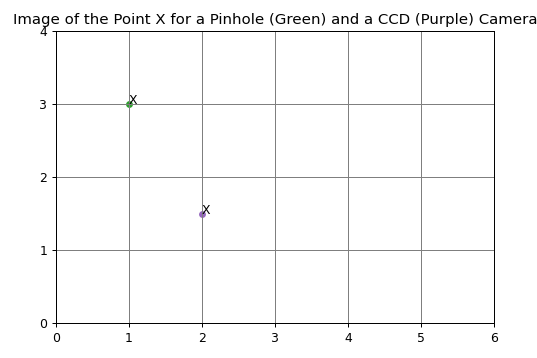

In [17]:
fig = plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGTH))
ax = fig.gca()
image.draw()
G.draw(F, px=PX, py=PY)
G.draw(F, px=PX, py=PY, mx=MX, my=MY, color="tab:purple")
ax.set_title("Image of the Point X for a Pinhole (Green) and a CCD (Purple) Camera")
plt.tight_layout()
plt.show()

As you can see from the graph, the coordinates of the point are multiplied by $m_x$ and $m_y$.

## Camera Projection Matrix

We have already introduced the camera projection matrix, let us now drop the hypothesis that there is no rotation or translation between the camera and the world frames, in this case the projection matrix of a CCD camera is

$$
\rm P = K R [I|-C] \,.
$$

We can therefore view the new camera model in both 3D and 2D.

In [18]:
FOCAL_LENGTH = 3.0  # focal length
PX= 2.0  # principal point x-coordinate
PY= 1.0  # principal point y-coordinate
MX = 1.0  # number of pixels per unit distance in image coordinates in x direction
MY = 1.0  # number of pixels per unit distance in image coordinates in y direction
THETA_X = np.pi / 2.0  # roll angle
THETA_Y = 0.0  # pitch angle
THETA_Z = np.pi  # yaw angle
C = np.array([3, -5, 2])  # camera centre
IMAGE_HEIGTH = 4
IMAGE_WIDTH = 6


calibration_kwargs = {"f": FOCAL_LENGTH, "px": PX, "py": PY, "mx": MX, "my": MY}
rotation_kwargs = {"theta_x": THETA_X, "theta_y": THETA_Y, "theta_z": THETA_Z}
projection_kwargs = {**calibration_kwargs, **rotation_kwargs, "C": C}

In [19]:
K = get_calibration_matrix(**calibration_kwargs)
print("Calibration matrix (K):\n", K.round(DECIMALS))
R = get_rotation_matrix(**rotation_kwargs)
print("\nRotation matrix (R):\n", R.round(DECIMALS))
P = get_projection_matrix(**projection_kwargs)
print("\nProjection matrix (P):\n", P.round(DECIMALS))

Calibration matrix (K):
 [[3. 0. 2.]
 [0. 3. 1.]
 [0. 0. 1.]]

Rotation matrix (R):
 [[-1. -0.  0.]
 [ 0. -0.  1.]
 [ 0.  1.  0.]]

Projection matrix (P):
 [[-3.  2.  0. 19.]
 [ 0.  1.  3. -1.]
 [ 0.  1.  0.  5.]]


In [20]:
dx, dy, dz = np.eye(3)
world_frame = ReferenceFrame(
    origin=np.zeros(3), 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
camera_frame = ReferenceFrame(
    origin=C, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=C,
    camera_dz=camera_frame.dz,
    f=F,
)
image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Image",
)
image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
    mx=MX,
    my=MY,
)
image = Image(heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH)
square1 = Polygon(np.array([
    [-1.0, 5.0, 4.0],
    [1.0, 3.0, 5.0],
    [1.0, 2.0, 2.0],
    [-1.0, 4.0, 1.0],
]))
square2 = Polygon(np.array([
    [-2.0, 4.0, 5.0],
    [2.0, 4.0, 5.0],
    [2.0, 4.0, 1.0],
    [-2.0, 4.0, 1.0],
]))

<IPython.core.display.Javascript object>


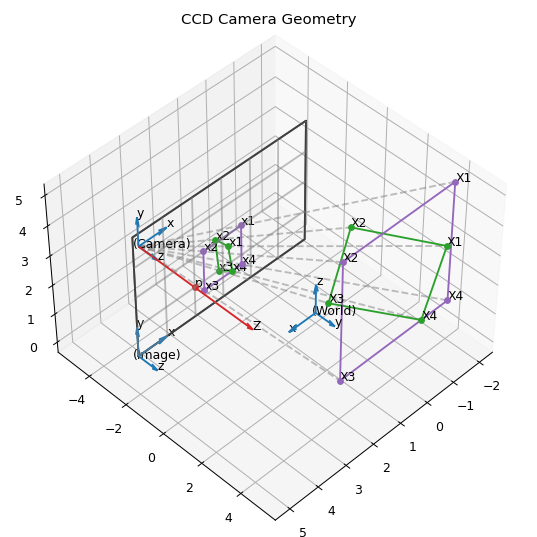

<IPython.core.display.Javascript object>


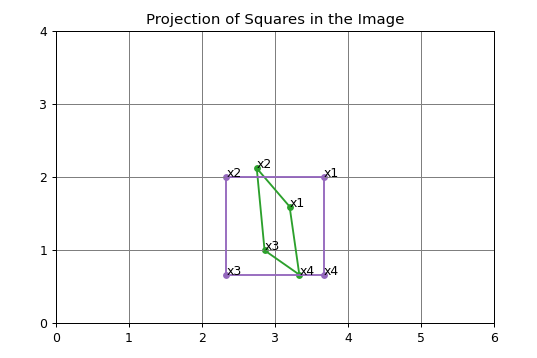

In [21]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()
square1.draw3d(pi=image_plane.pi, C=C)
square2.draw3d(pi=image_plane.pi, C=C, color="tab:purple")
ax.view_init(elev=45.0, azim=45.0)
ax.set_title("CCD Camera Geometry")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGTH))
ax = fig.gca()
image.draw()
square1.draw(**projection_kwargs)
square2.draw(**projection_kwargs, color="tab:purple")
ax.set_title("Projection of Squares in the Image")
plt.tight_layout()
plt.show()

## Final Thoughts

That's it! You can now play with the parameters above to improve your understanding of the concepts introduced in this notebook. I would also advise you not to limit yourself to using the functions but to go and see how they are implemented. If you have any questions about the topics covered here, connect with me and write me a message, within the limits of my knowledge and time I will try to answer you.

Here my contacts:
* **LinkedIn**: https://www.linkedin.com/in/mnslarcher
* **Twitter**: https://twitter.com/mnslarcher